# Searching for Signals using Matched Filters

In this notebook we will go through the basics of matched filters and see how powerful this method can be. The basic idea is as follows: if a signal is buried in noise that is much stronger, you can still detect that signal, if you know what you are looking for.

If you're interested in the mathematics behind the methods we will be using, you can have a look on [Wikipedia](https://en.wikipedia.org/wiki/Matched_filter); but with this notebook you will hopefully get the ideas clear heuristically by getting your hands dirty yourself.

### Chirp signals

Let's first define a function that will generate the signals we are interested in. This function, `chirp`, mimics the shape of gravitational wave signals sent out by inspiraling binary star systems. It is an enormous simplification, as the actual shapes of these signals are [far too complicated](https://arxiv.org/pdf/0907.0700v1.pdf) for our purposes.

We just take a simple sinusoidal signal, with some alterations. The basic parameters of the signal are an overal `offset`, a constant background term, the amplitude `A` of the oscillations, and their frequency `f`.

The main feature of these gravitational wave signals is that, as the two stars spiral towards each other and eventually collide, both the frequency and the amplitude of the signal increase, much like the chirp of a bird. We mimic this by adding two more parameters, `dA` and `df`, that linearly increase the amplitude and the frequency in time.

Finally, we add a parameter `tc` which encodes the _time of coalescence_, the moment in time when the two stars of the binary system collide. At this point the oscillatory behavior of the signal is terminated and only the background term remains.

All of this put together yields the following function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc
import math
np.random.seed(0) # For reproducibility


def chirp(t, tc, offset, A, dA, f, df):
    """
    Generate a chirp signal.
    
    Arguments:
    t      -- array-like containing the times at which to evaluate the signal.
    tc     -- time of coalescence, after which the signal is terminated; for times beyond tc the signal is set to the constant background.
    offset -- constant background term
    A      -- initial signal amplitude at t=0
    dA     -- linear coefficient describing the increase of the amplitude with time
    f      -- initial signal frequency at t=0
    df     -- linear coefficient describing the increase of the frequency with time
    """
    chirp = offset + (A + dA*t) * np.sin(2*math.pi*(f + df*t) * t)
    chirp[t>tc] = offset
    return chirp

So what does such a signal look like? Let's choose some values for the parameters and have a look at a plot.

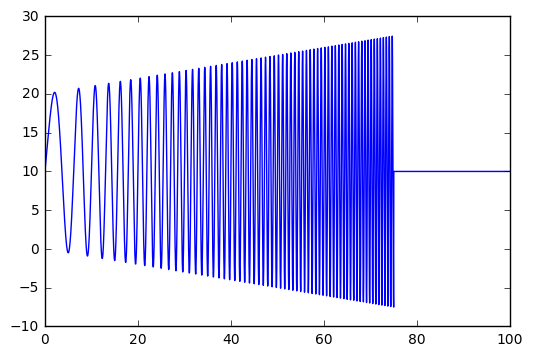

In [2]:
# Injected values for our artificial signal
tc_true = 75
offset_true = 10
A_true = 10
dA_true = 0.1
f_true = 0.1
df_true = 0.01

# Noise strength
sigma = 250

# Our time points
t = np.linspace(0,100,10001)

# Our injection signal
y_true = chirp(t, tc_true, offset_true, A_true, dA_true, f_true, df_true)

# Let's have a look at our signal!
plt.plot(t,y_true)
plt.show()

As you can see, the signal oscillates faster and faster as well as louder and louder, until at `t = tc` the oscillations collapse.

Now we want to simulate the very heavy noise that we have to deal with in gravitational wave detectors. Let's generate some gaussian-distributed noise and inject our signal into it.

In [3]:
# We add some uninteresting stretches of data before and after the signal
signal = np.concatenate((np.repeat(offset_true,2100),y_true,np.repeat(offset_true,2900)))

# The noise is normally distributed with standard deviation sigma.
noise = np.random.normal(0,sigma,len(signal))

Here is what the resulting data looks like when we inject our signal into the noise:

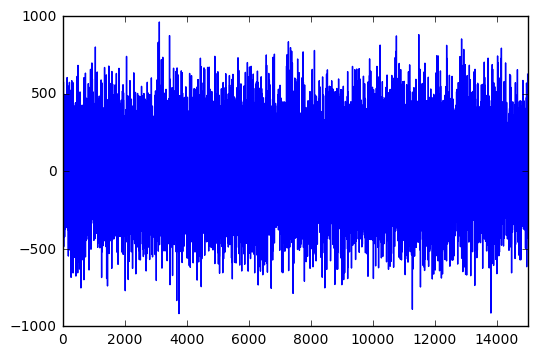

In [4]:
plt.xlim([0,len(signal)])
plt.plot(signal+noise)
plt.show()

Can you see the signal in there? I didn't think so. The noise we generated is more than an order of magnitude stronger than the signal, which is completely buried. If you didn't know there was a signal to be found, you would probably think that is just noise.

But the signal is really in there; it's just very small:

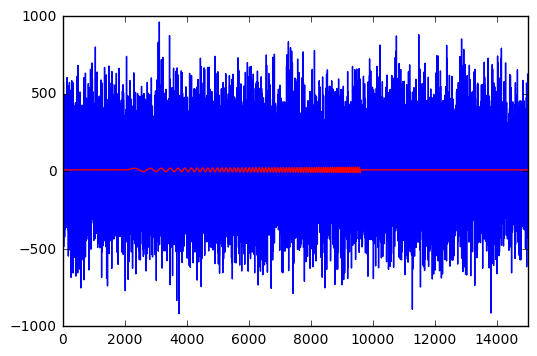

In [5]:
plt.xlim([0,len(signal)])
plt.plot(signal+noise)
plt.plot(signal, color='r')
plt.show()

So how could we ever hope to find that signal? Definitely not by eye. Luckily we are not entirely clueless as to what signals we might find in the output of a gravitational wave detector. Inspiraling binary star systems are among the most promising sources of gravitational waves, and we may well expect to find chirp signals. So why don't we do just that? Let's see what we can do if we know what signal to expect.

### The Matched Filter

In its simplest form, a matched filter is a signal processing method that tries to determine where a signal is in the data. It presupposes that

1) you know that there is a signal in the data; and
2) you know the shape of the signal exactly.

These are very stringent requirements for most data analysts, and we will loosen them considerably, but even in this basic form it has its applications. For instance in radar and sonar systems, where a known signal is sent out and expected to bounce off of objects and return to the source in more or less the same shape, it's a useful tool.

Mathematically, the matched filter works as follows. Take a noisy time series $d(t)$, in which you know there is some signal $h(t)$ to be found,

$$d(t) = n(t) + h(t-t_0),$$

i.e. the data consists of random noise plus some signal starting at time $t_0$. We now take the signal we expect (the 'template') and slide it along your data, seeing where it fits best. We do this by multiplying the data and the template at each time point: 

$$y = \sum_n d(t_n) h(t_n - t_0)$$

Now, if we have chosen $t_0$ incorrectly, we are just multiplying our template with random values,

$$y = \sum_n n(t_n) h(t_n - t_0)$$

making some parts of the sum positive, some negative, and the whole thing should average out to zero. However, if we have aligned our template with the actual signal in the data, we get

$$y = \sum_n n(t_n) h(t_n - t_0) + \sum_n h(t_n - t_0) h(t_n - t_0).$$

The first part will still be zero, on average, but the second term is a sum of squares and should yield a strong positive number, indicating that we have found the signal.

If we just do the above for every possible offset $t_0$, $y(t_0)$ should have a maximum at the point in time where the actual signal is.

So let's see if this can help us detect our gravitational wave signal.

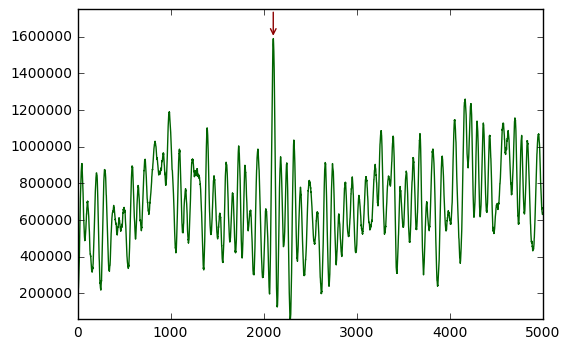

In [6]:
# Applying the filter is just calculating a convolution
filtered=np.convolve(y_true[::-1],signal+noise, mode='valid')

# And then we want to know where the maximum value of this convolution is
pos=np.argmax(filtered)

# Let's plot the result
plt.ylim([1.1*min(filtered), 1.1*max(filtered)])
plt.plot(filtered, c='darkgreen')

# And have an arrow point at the maximum
plt.annotate("", xytext=(pos, 1.1*max(filtered)), xy=(pos, max(filtered)),
    arrowprops=dict(arrowstyle="->", edgecolor='darkred'))

plt.show()

We see that the maximum lies at an offset of 2100 samples, which is exactly where we placed our signal! So, even such a tiny signal, buried in noise that is much, much stronger, can still be found with this method.

### Exercise 1
1. As you see, in this case the 'bad' values of the filtered signal are not evenly distributed around zero. Can you explain why? Is it important?
2. Can you think of any other method for finding the signal in the data if you know what the signal looks like? Does it work as well as the matched filter?

# Parameter estimation with template banks

Of course, in general we are not going to have the luxury of knowing exactly what our signal looks like. It may depend on any number of parameters, like our chirp signal. But that doesn't need to stop us from finding it!

Let's assume that we at least know a reasonable functional form for the signals we are looking for, so that we can write a function like `chirp`. For gravitational waves this can be done for certain classes of signals, such as the binary star systems we've talked about. Einstein's theory of relativity in principle predicts what the signals should look like (hard to calculate though they may be.)

If we have that, then we can build a template bank: for matched filtering we need a template; if we don't know exactly what the template should look like, let's just try all of them!

Above, we were essentially already doing parameter estimation: we were trying to find out at which time the signal starts. To do so we found that there is a quantity we can maximize. Extending the problem to other parameters is no different: just try different values of your parameters and see which one yields the biggest value for the matched filter!

### Matched filter as maximum likelihood estimator

Before we actually do that, though, we are going to change up the mathematical language we use a little. The matched filter as performed above using convolution is nice for demonstration purposes, but we'll now look at the matched filter as a way of maximizing the _likelihood_ of the parameters to be estimated. This is not entirely equivalent to what we did above, but the idea is the same. 

The [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) tells us the probability of the observed data if we assume certain values for the parameters. For example, suppose we have Gaussian noise with variance $\sigma^2$, possibly contianing a signal, and a template function $h(\theta)$ where $\theta$ is a set of parameters. If we believe those parameters, then we believe that the noise looks like

$$n(t, \theta) = d(t) - h(t, \theta).$$

But we know that the noise should be random, so if it does not look like it is properly distributed according to a gaussian distribution, we probably chose the wrong parameters. To quantify that idea, the likelihood of the parameters can be calculated by

$$L(\theta) = P(n(t, \theta)) = \prod_{i} e^{-n^2(t_i)/\sigma^2}.$$

The last part is just the probability of the noise realization, given that we know its Gaussian distribution. The added benefit of this method is that we actually get probabilities distributions for the parameters we want to estimate.

### Log-likelihood and (log) Odds ratio

It is usually most convenient to work with the logarithm of the likelihood. We now define functions to calculate this log-likelihood, as well as the (log of the) Odds ratio, which is a ratio between likelihoods of two different signals. In the following, we will compare the likelihoods of our signals to that of a zero-signal, i.e. the assumption that there is no signal in the data. This makes the numbers more meaningful:

- Positive odds ratio means the template fits better than assuming no signal is present;
- Negative odds ratio means the template fits worse, meaning the parameters are probably very wrong.

In [7]:
# Calculating the logarithmic likelihood is easier as it is just a sum, rather than a product
def log_likelihood(data, signal, sigma):
    noise = data - signal
    L = np.sum(-noise**2/sigma**2)
    return L

# The odds ratio between a template and a zero-signal
def O(data, template, sigma):
    zero_signal = np.zeros(len(template)) 
    O = np.sum((data-zero_signal)**2 - (data-template)**2)/sigma**2
    return O

In [8]:
# Let's generate some noise and inject our signal
noise = np.random.normal(0,sigma,len(y_true))
data = noise + y_true

In [9]:
# The odds of the true signal are of course much better than the odds of the zero-signal
O(data, y_true, sigma)

33.298957479806404

In [10]:
# What if we look for the wrong signal, like the real signal in reverse?
# The odds are still better than the zero-signal, but much worse than the real signal.
# Remember, these numbers are on a logarithmic scale!
O(data, y_true[::-1], sigma)

24.078074844782517

In [11]:
# If we take a completely nonsensical signal, such as expecting
# a large constant offset, the odds are worse than for the
# zero-signal.
O(data, np.repeat(35,len(y_true)), sigma)

-54.193588383500007

In [12]:
# The odds ratio of the zero-signal will of course yield 0 by definition.
zero_signal = np.zeros(len(y_true))
O(data, zero_signal, sigma)

0.0

### Searching the parameter space

So now let's use our new mathematical machinery to search the parameter space for parameters with high likelihood. The simplest thing we can do is just do a grid search.

In our case, the `chirp` function is simple enough that we can just generate templates on the fly. Real gravitational waves templates, however, are computationally very costly to produce. In such a case, it may make more sense to generate a big template bank in advance and use that for your grid search.

In [13]:
# Let's search for the maximum odds ratio we can find...
Omax = 0
# ...and the associated parameters. We will just search in two dimensions:
# the base amplitude and base the frequency.
Amax = 0
fmax = 0

# Injection values for our parameters
A_true = 10
f_true = 0.1

# Defining our grid. Of course we're cheating a little by zooming
# in on the true values.
A_range = np.linspace(0,2*A_true,100)
f_range = np.linspace(0,2*f_true,100)

# And an array to store all the odds ratio values
Ofun = np.empty((len(A_range),len(f_range)))

# And then just loop over all possible parameter combinations
for i in range(len(A_range)):
    for j in range(len(f_range)):
        # Calculate the odds ratio
        Ocur = O(data, chirp(t, tc_true, offset_true, A_range[i], dA_true, f_range[j], df_true), sigma)
        Ofun[i][j] = Ocur
        
        # And keep track of the maximum
        if Ocur > Omax:
            Omax = Ocur
            Amax = A_range[i]
            fmax = f_range[j]

# Did we find the right values?
print(A_true, Amax)
print(f_true, fmax)
print(Omax)

10 9.49494949495
0.1 0.10101010101
35.3795953551


We did not find the exact values of the parameters, but we're pretty close.

Let's visualize the odds ratios for our template bank. The blue dot represents the real parameter values, the red dot the ones we estimated to be the real ones.

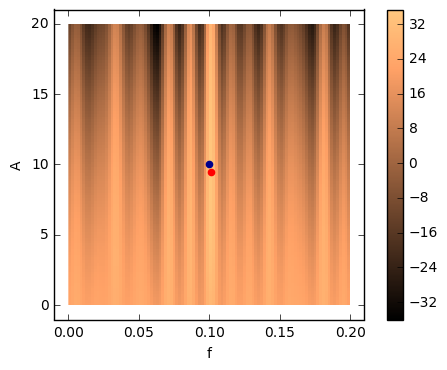

In [14]:
# Plot our log odds function
plt.imshow(Ofun, interpolation='none', extent=[0, 2*f_true, 0, 2*A_true], origin='lower', aspect=f_true/A_true, \
          cmap='copper')

# Add a colorbar for scale
plt.colorbar()

# Add the injected and recovered values
plt.scatter([fmax], [Amax], color='red')
plt.scatter([f_true], [A_true], color='darkblue')

# Plot
plt.xlabel('f')
plt.ylabel('A')
plt.show()

### Exercise 2
It is interesting to have a look at how the odds ratio varies as you vary the parameters.

1. Does an incorrect choice of amplitude lead immediately to a very low odds ratio? Can you think of an explanation for this?
2. The odds ratio seems to oscillate as you change the frequency; can you explain why?
3. In the ranges we specified for the parameters, we can get to negative odds ratios by choosing the wrong frequency, but not by choosing the wrong amplitude. Are there any values for the amplitude that would lead to negative odds ratios?



## Concluding remarks

We've now seen how to do basic parameter estimation using matched filtering. Employing a grid search, we even got a sense of the probability distribution of the parameters.

In reality, there are of course generally more than two parameters to estimate, and we don't have the luxury of knowing which part of the grid to zoom into. We could start with a wide grid and then iteratively narrow it down, but in reality recourse is generally taken to statistical methods. In the second part of this session, we'll look at how to do parameter estimation using Monte Carlo techniques.